<a href="https://colab.research.google.com/github/MarcCampmanyGar/Nuclio_DS_Projects/blob/main/03_KMeans_with_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = "table_of_contents"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA customers df](#df1)

---> [EDA orders df](#df2)

---> [EDA payments df](#df3)

[Creación de variables](#fe)

[Join final con clientes y variables finales](#join)

[Creación de nuestro Pipeline](#skpipeline)

[Elbow curve](#elbow_curve)

[Segmentación de los clientes con la "k adecuada"](#segmentacion)

[Modelo RFM](#rfm)

[Ficha de clientes](#ficha)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

En este notebook vamos a trabajar con el dataset de la **compañia brasileña de E-Commerce llamada Olist.**

La compañia opera con una filosofía de ***SaaS (Software as a Service)***. Su producto básico es un marketplace donde tiendas **con o sin presencia online pueden vender sus productos a los clientes que visitan su web.**

![Data Model](https://i.imgur.com/HRhd2Y0.png)

Utilizando el dataset de Olist (alrededor de 100 mil registros) vamos a construir una segmentacion basada en el algoritmo KMeans. El enfoque a la hora de construir variables será basado en el modelo de ***RFM (recency - frequency - monetary value).*** Esta es una forma de trabajar muy común en startups y tiendas online donde se dispone de poca información de los clientes y la retención/canje de los clicks es fundamental.

Nuestros principales objetivos serán:
1. **Construir variables de negocio (pensadas para nuestra segmentación)** a partir de 3 datasets diferentes y juntarlos de forma correcta para no generar duplicidades de registros.



2. **Aprender a utilizar el Pipeline de sklearn** para agilizar mucho la transformación del dataset y la creación de variables.



3. **Aprender a implementar nuestros propios Transformers** que se puedan usar dentro de los Pipelines (por ejemplo para eliminar los outliers).



4. Usar el diagrama del codo para determinar la cantidad **"óptima"** de centroides para el modelo de KMeans.



5. **Resumir la información de nuestros clústers en un formato más amigable** usando Pandas (fichas de clientes).

<a id = "import_modules"></a>
# Importación de las principales librerías
[Volver al índice](#table_of_contents)

En esta sección del kernel vamos a cargar las principales librerías que vamos a usar en nuestro notebook durante la implementación del algoritmo **KMeans.**

In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 175
PATH_FOLDER = os.path.join(os.getcwd(), "olist_datasets")

In [ ]:
import sklearn
print(sklearn.__version__)

1.0.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_FOLDER = '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Unsupervised/03_KMeans/olist_datasets'

<a id = "import_data"></a>
# Importación de los datos
[Volver al índice](#table_of_contents)

En la presente sección del kernel vamos a cargar los principales datasets que vamos a usar para nuestra segmentación.

El alumno puede **añadir otros datasets o datos externos** para profundizar o experimentar con el algoritmo KMeans.

In [ ]:
PATH_CUSTOMERS = os.path.join(PATH_FOLDER, 'olist_customers_dataset.csv')

customer_df = pd.read_csv(PATH_CUSTOMERS)

In [ ]:
PATH_ORDERS = os.path.join(PATH_FOLDER, 'olist_orders_dataset.csv')

orders_df = pd.read_csv(PATH_ORDERS)

In [ ]:
PATH_PAYMENTS = os.path.join(PATH_FOLDER, 'olist_order_payments_dataset.csv')

payments_df = pd.read_csv(PATH_PAYMENTS)

<a id = "eda"></a>
# Exploratory Data Analysis (EDA)
[Volver al índice](#table_of_contents)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
# EDA customers df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de clientes.**

In [ ]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [ ]:
report_df(customer_df)

customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Tenemos un total de 0 nulos


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customer_id = customer_df["customer_id"].nunique()
customer_unique_id = customer_df["customer_unique_id"].nunique()

print(f'''Tenemos un total de {customer_unique_id} clientes únicos,\n
para un total de {customer_id} pedidos (en el esquema de Olist, especifican que el id único es customer_unique_id\n
y que customer_id es un id que se genera en cada compra y por tanto a la práctica viene a ser lo mismo que un pedido).
Esto implica un ratio de {round(customer_id/customer_unique_id, 2)} pedidos por cliente.
''')

Tenemos un total de 96096 clientes únicos,

para un total de 99441 pedidos (en el esquema de Olist, especifican que el id único es customer_unique_id

y que customer_id es un id que se genera en cada compra y por tanto a la práctica viene a ser lo mismo que un pedido).
Esto implica un ratio de 1.03 pedidos por cliente.



In [ ]:
# create a groupby DataFrame by customer city
city_pivot_ = customer_df.groupby(["customer_state", "customer_city"]).size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_city"})

city_pivot_["cumsum_by_city"] = (city_pivot_["clients_per_city"]/city_pivot_["clients_per_city"].sum()).cumsum()

city_pivot_["pct_cities"] = (1/city_pivot_.shape[0])
city_pivot_["pct_cities"] = city_pivot_["pct_cities"].cumsum()

In [ ]:
city_pivot_

,customer_state,customer_city,clients_per_city,cumsum_by_city,pct_cities
0,SP,sao paulo,15540,0.156274,0.000232
1,RJ,rio de janeiro,6882,0.225480,0.000464
2,MG,belo horizonte,2773,0.253366,0.000696
3,DF,brasilia,2131,0.274796,0.000928
4,PR,curitiba,1521,0.290092,0.001160
...,...,...,...,...,...
4305,MG,felixlandia,1,0.999960,0.999072
4306,RS,barao do triunfo,1,0.999970,0.999304
4307,MG,fonseca,1,0.999980,0.999536
4308,RS,barao,1,0.999990,0.999768


In [ ]:
(city_pivot_["clients_per_city"] / city_pivot_['clients_per_city'].sum()).cumsum()  #al final de la columna suma 1, va sumant cada valor

0       0.156274
1       0.225480
2       0.253366
3       0.274796
4       0.290092
          ...   
4305    0.999960
4306    0.999970
4307    0.999980
4308    0.999990
4309    1.000000
Name: clients_per_city, Length: 4310, dtype: float64

In [ ]:
# create a groupby DataFrame by customer state
state_pivot_ = customer_df.groupby("customer_state").size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_state"})

state_pivot_["cumsum_by_state"] = (state_pivot_["clients_per_state"]/state_pivot_["clients_per_state"].sum()).cumsum()

state_pivot_["pct_state"] = (1/state_pivot_.shape[0])
state_pivot_["pct_state"] = state_pivot_["pct_state"].cumsum()

In [ ]:
state_pivot_

,customer_state,clients_per_state,cumsum_by_state,pct_state
0,SP,41746,0.419807,0.037037
1,RJ,12852,0.549049,0.074074
2,MG,11635,0.666053,0.111111
3,RS,5466,0.721021,0.148148
4,PR,5045,0.771754,0.185185
5,SC,3637,0.808329,0.222222
6,BA,3380,0.842319,0.259259
7,DF,2140,0.863839,0.296296
8,ES,2033,0.884283,0.333333
9,GO,2020,0.904597,0.370370


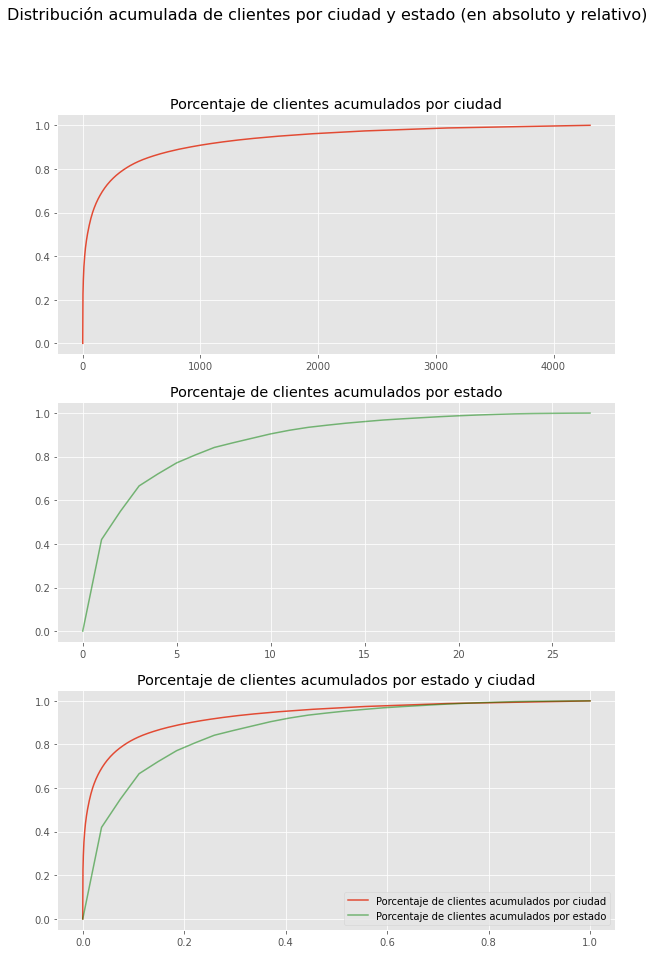

In [ ]:
#----------------------
# Plotting part

# instanciate the figure
fig = plt.figure(figsize = (10, 15))
ax1, ax2, ax3 = fig.subplots(nrows = 3, ncols = 1)

# get the data
# concate a zero before the list, so that all curves start at origin
x1_values = [0] + list(city_pivot_.index)
y1_values = [0] + list(city_pivot_["cumsum_by_city"])

x2_values = [0] + list(state_pivot_["cumsum_by_state"])
y2_values = [0] + list(state_pivot_["cumsum_by_state"])

x3_values_city = [0] + list(city_pivot_["pct_cities"])
y3_values_city = [0] + list(city_pivot_["cumsum_by_city"])

x3_values_state = [0] + list(state_pivot_["pct_state"])
y3_values_state = [0] + list(state_pivot_["cumsum_by_state"])

# plot the values and set for every subplot a title
ax1.plot(y1_values)
ax1.title.set_text("Porcentaje de clientes acumulados por ciudad")

ax2.plot(y2_values, color = "green", alpha = 0.5)
ax2.title.set_text("Porcentaje de clientes acumulados por estado")

ax3.plot(x3_values_city, y3_values_city, label = "Porcentaje de clientes acumulados por ciudad")
ax3.plot(x3_values_state, y3_values_state, label = "Porcentaje de clientes acumulados por estado", 
         color = "green", alpha = 0.5)
ax3.title.set_text("Porcentaje de clientes acumulados por estado y ciudad")

ax3.legend()

# create a title for the figure
fig.suptitle('Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)', fontsize = 16);

<a id = "df2"></a>
# EDA orders df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pedidos.**

In [ ]:
report_df(orders_df)

orders_df.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Tenemos un total de 4908 nulos


,0,1,2
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [ ]:
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# tenemos nulls en las fechas, habrá o bien eliminar estos nulos o imputarles una fecha.
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
order_id = orders_df["order_id"].nunique()
customer_id_orders = orders_df["customer_id"].nunique()

# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
assert (set(orders_df["customer_id"]) ^ set(customer_df["customer_id"])) == set()
assert (set(customer_df["customer_id"]) ^ set(orders_df["customer_id"])) == set()

print(f"Tenemos un total de {order_id} pedidos")
print(f"Tenemos un total de {customer_unique_id} customer únicos (de la tabla de customers)")
print(f"La relación de pedidos por clientes es de {round(order_id/customer_unique_id, 2)}")

Tenemos un total de 99441 pedidos
Tenemos un total de 96096 customer únicos (de la tabla de customers)
La relación de pedidos por clientes es de 1.03


<a id = "df3"></a>
# EDA payments df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pagos.**

In [ ]:
report_df(payments_df)

payments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None

Tenemos un total de 0 nulos


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
payments_df['payment_sequential'].value_counts().sort_index()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
16        6
17        6
18        6
19        6
20        4
21        4
22        3
23        2
24        2
25        2
26        2
27        1
28        1
29        1
Name: payment_sequential, dtype: int64

In [ ]:
payments_df['payment_installments'].value_counts().sort_index()

0         2
1     52546
2     12413
3     10461
4      7098
5      5239
6      3920
7      1626
8      4268
9       644
10     5328
11       23
12      133
13       16
14       15
15       74
16        5
17        8
18       27
20       17
21        3
22        1
23        1
24       18
Name: payment_installments, dtype: int64

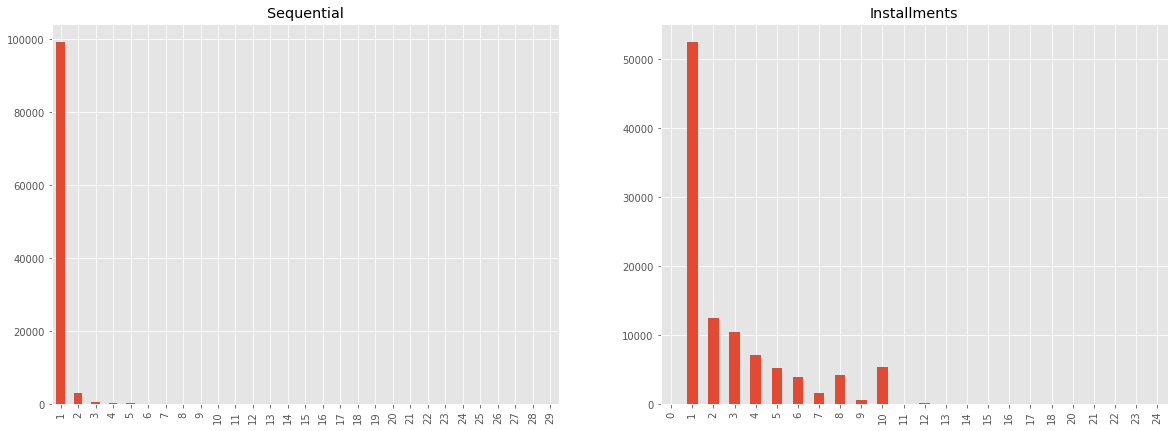

In [ ]:
fig = plt.figure(figsize = (20,7))
ax1, ax2 = fig.subplots(1,2)

payments_df['payment_sequential'].value_counts().sort_index().plot(kind = 'bar', ax=ax1, title='Sequential')

payments_df['payment_installments'].value_counts().sort_index().plot(kind='bar', ax=ax2, title = 'Installments')

In [ ]:
order_id_pay = payments_df["order_id"].nunique()
print(f"Tenemos un total de {order_id_pay} pedidos únicos en la tabla de payments")

Tenemos un total de 99440 pedidos únicos en la tabla de payments


In [ ]:
# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
len(set(orders_df["order_id"]))

99441

In [ ]:
#te saca todas las diferencias entre los dos sets
set(orders_df["order_id"]) ^ set(payments_df["order_id"])

{'bfbd0f9bdef84302105ad712db648a6c'}

In [ ]:
orders_df[orders_df["order_id"] == "bfbd0f9bdef84302105ad712db648a6c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


<a id = "fe"></a>
# Creación de variables
[Volver al índice](#table_of_contents)

Hemos analizado los 3 datasets claves con los que vamos a trabajar.

En esta sección del notebook, **iremos agregando el dataset y vamos a generar nuevas variables** para que después en la siguiente sección lo juntamos en uno y hacemos la segmentación.

In [ ]:
payments_df['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
ee9ca989fc93ba09a6eddc250ce01742    19
                                    ..
67b2034550d68134bdb9bac8c1988c39     1
6c8fdc6f1b35e5126442a74c3bcc36d5     1
a7adf8d0ab081caab51b96af34523e00     1
3adb141ba4bd69dd7fe8d3fb733c6b74     1
992738bb51e7ba624763bd8060189c5e     1
Name: order_id, Length: 99440, dtype: int64

In [ ]:
order_id_ = 'fa65dad1b0e818e3ccc5cb0e39231352'

In [ ]:
payments_df.groupby('order_id').get_group((order_id_)).head()     #sense el head serien 29 files, pq relacionats a aquest order_id hi han 29 payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


In [ ]:
# hacemos un groupby por order y calculamos algunas métricas básicas como max, min, media y similares.
# Hemos visto que gran parte de los pagos son únicos, por tanto coincidirán en la mayoría, pero en los demás casos
# nos van a aportar información útil sobre el cliente.

aggregated_payments = payments_df.groupby('order_id').agg(
    max_pay = ('payment_value', 'max'), 
    min_pay = ('payment_value', 'min'),
    mean_pay = ('payment_value', 'mean'),
    total_pay = ('payment_value', 'sum'),
    max_seq = ('payment_sequential', 'max')
)

In [ ]:
aggregated_payments

,max_pay,min_pay,mean_pay,total_pay,max_seq
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,72.19,72.19,72.19,1
00018f77f2f0320c557190d7a144bdd3,259.83,259.83,259.83,259.83,1
000229ec398224ef6ca0657da4fc703e,216.87,216.87,216.87,216.87,1
00024acbcdf0a6daa1e931b038114c75,25.78,25.78,25.78,25.78,1
00042b26cf59d7ce69dfabb4e55b4fd9,218.04,218.04,218.04,218.04,1
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,343.40,343.40,343.40,343.40,1
fffcd46ef2263f404302a634eb57f7eb,386.53,386.53,386.53,386.53,1
fffce4705a9662cd70adb13d4a31832d,116.85,116.85,116.85,116.85,1


In [ ]:
aggregated_payments.loc[order_id_]   #vemos que las 29 filas de ese order id ahora se muesta toda la info en una sola línea

max_pay      150.000000
min_pay        0.000000
mean_pay      15.792759
total_pay    457.990000
max_seq       29.000000
Name: fa65dad1b0e818e3ccc5cb0e39231352, dtype: float64

In [ ]:
aggregated_payments[aggregated_payments["max_seq"] == 29]

,max_pay,min_pay,mean_pay,total_pay,max_seq
order_id,,,,,
fa65dad1b0e818e3ccc5cb0e39231352,150.0,0.0,15.792759,457.99,29


In [ ]:
payments_df.shape

(103886, 5)

In [ ]:
aggregated_payments.shape

(99440, 5)

In [ ]:
orders_df.shape

(99441, 8)

In [ ]:
orders_with_payments = pd.merge(
      orders_df, 
      aggregated_payments, 
      on = 'order_id'
)

In [ ]:
orders_with_payments.shape

(99440, 13)

In [ ]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99440 non-null  object 
 1   customer_id                    99440 non-null  object 
 2   order_status                   99440 non-null  object 
 3   order_purchase_timestamp       99440 non-null  object 
 4   order_approved_at              99280 non-null  object 
 5   order_delivered_carrier_date   97657 non-null  object 
 6   order_delivered_customer_date  96475 non-null  object 
 7   order_estimated_delivery_date  99440 non-null  object 
 8   max_pay                        99440 non-null  float64
 9   min_pay                        99440 non-null  float64
 10  mean_pay                       99440 non-null  float64
 11  total_pay                      99440 non-null  float64
 12  max_seq                        99440 non-null 

In [ ]:
orders_with_payments[orders_with_payments['order_id']==order_id_]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_pay,min_pay,mean_pay,total_pay,max_seq
25932,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,shipped,2017-04-20 12:45:34,2017-04-22 09:10:13,2017-04-24 11:31:17,NaN,2017-05-18 00:00:00,150.0,0.0,15.792759,457.99,29


In [ ]:
orders_with_payments.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_pay,min_pay,mean_pay,total_pay,max_seq
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,2.00,12.903333,38.71,3
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,141.46,141.460000,141.46,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,179.12,179.120000,179.12,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,72.20,72.200000,72.20,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,28.62,28.620000,28.62,1


In [ ]:
#orders_with_payments["order_id_back"] = orders_with_payments["order_id"]
orders_with_payments.set_index('order_id', inplace = True)

In [ ]:
orders_with_payments.head()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_pay,min_pay,mean_pay,total_pay,max_seq
order_id,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,2.00,12.903333,38.71,3
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,141.46,141.460000,141.46,1
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,179.12,179.120000,179.12,1
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,72.20,72.200000,72.20,1
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,28.62,28.620000,28.62,1


In [ ]:
# convertimos las fechas al formato fechas dado que hasta ahora eran object y no nos permitían hacer
# casi ninguna transformación

orders_with_payments['order_purchase_timestamp'] =\
pd.to_datetime(orders_with_payments['order_purchase_timestamp'], format = '%Y-%m-%d')

orders_with_payments['order_delivered_customer_date'] =\
pd.to_datetime(orders_with_payments['order_delivered_customer_date'], format = '%Y-%m-%d')

In [ ]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99440 non-null  object        
 1   order_status                   99440 non-null  object        
 2   order_purchase_timestamp       99440 non-null  datetime64[ns]
 3   order_approved_at              99280 non-null  object        
 4   order_delivered_carrier_date   97657 non-null  object        
 5   order_delivered_customer_date  96475 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99440 non-null  object        
 7   max_pay                        99440 non-null  float64       
 8   min_pay                        99440 non-null  float64       
 9   mean_pay                       99440 non-null  float64       
 10  total_pay                    

In [ ]:
orders_with_payments['order_estimated_delivery_date'] =\
pd.to_datetime(orders_with_payments['order_estimated_delivery_date'], format = '%Y-%m-%d')

In [ ]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99440 non-null  object        
 1   order_status                   99440 non-null  object        
 2   order_purchase_timestamp       99440 non-null  datetime64[ns]
 3   order_approved_at              99280 non-null  object        
 4   order_delivered_carrier_date   97657 non-null  object        
 5   order_delivered_customer_date  96475 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 7   max_pay                        99440 non-null  float64       
 8   min_pay                        99440 non-null  float64       
 9   mean_pay                       99440 non-null  float64       
 10  total_pay                    

In [ ]:
# creamos variables útiles extrayendo la información de los pedidos.
# Por ejemplo: tiempo desde la última compra puede ser muy útil para que nuestro modelo detecte clientes
# recientes y combinando con la variable de pedidos totales podrá ser muy valiosas para segmentar a los clientes
# muy fidelizados.

orders_with_payments['last_purchase'] = orders_with_payments['order_purchase_timestamp'].max()

orders_with_payments['time_since_last_purchase'] =\
orders_with_payments['last_purchase'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delivery_time'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delay'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_estimated_delivery_date']

In [ ]:
orders_with_payments.head().T

order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c
order_status,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,2017-11-18 19:45:59,2018-02-13 22:20:29
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00
max_pay,18.59,141.46,179.12,72.2,28.62
min_pay,2,141.46,179.12,72.2,28.62
mean_pay,12.9033,141.46,179.12,72.2,28.62


<a id = "join"></a>
# Join final con clientes y variables finales
[Volver al índice](#table_of_contents)

In [ ]:
df_final = pd.merge(
    customer_df, 
    orders_with_payments, 
    on = "customer_id")

In [ ]:
#df_final.set_index("order_id_back", inplace = True)
df_final.set_index("customer_unique_id", inplace = True)

lc = [
    'max_pay',
    'min_pay',
    'mean_pay',
    'total_pay',
    'max_seq',
    'time_since_last_purchase',
    'delivery_time',
    'delay'
]

df_final = df_final[lc]

# extraemos los días de la variable timedelta que teníamos calculada previamente.
df_final["time_since_last_purchase"] = df_final["time_since_last_purchase"].dt.days
df_final["delivery_time"] = df_final["delivery_time"].dt.days
df_final["delay"] = df_final["delay"].dt.days

In [ ]:
df_final.head().T

customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066
max_pay,146.87,335.48,157.73,173.3,252.25
min_pay,146.87,335.48,157.73,173.3,252.25
mean_pay,146.87,335.48,157.73,173.3,252.25
total_pay,146.87,335.48,157.73,173.3,252.25
max_seq,1.00,1.00,1.00,1.0,1.00
time_since_last_purchase,519.00,277.00,151.00,218.0,80.00
delivery_time,8.00,16.00,26.00,14.0,11.00
delay,-11.00,-8.00,1.00,-13.0,-6.00


In [ ]:
report_df(df_final)

df_final.sample(3).T

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   max_pay                   99440 non-null  float64
 1   min_pay                   99440 non-null  float64
 2   mean_pay                  99440 non-null  float64
 3   total_pay                 99440 non-null  float64
 4   max_seq                   99440 non-null  int64  
 5   time_since_last_purchase  99440 non-null  int64  
 6   delivery_time             96475 non-null  float64
 7   delay                     96475 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 6.8+ MB
None

Tenemos un total de 5930 nulos


customer_unique_id,ac2230be6e3cf92bea664b00f91b60ee,e6a842f26a52b4012fa34ab9048e2fb5,c82138e1cee859f5fce250fe4bf620e3
max_pay,26.09,254.14,134.33
min_pay,26.09,254.14,134.33
mean_pay,26.09,254.14,134.33
total_pay,26.09,254.14,134.33
max_seq,1.00,1.00,1.00
time_since_last_purchase,494.00,160.00,59.00
delivery_time,9.00,6.00,10.00
delay,-23.00,-16.00,-2.00


# Preparar dataframe

In [ ]:
# tenemos valores nulos y habrá que imputarlas de forma correcta en nuestro pipeline.
df_final.isnull().sum()

max_pay                        0
min_pay                        0
mean_pay                       0
total_pay                      0
max_seq                        0
time_since_last_purchase       0
delivery_time               2965
delay                       2965
dtype: int64

In [ ]:
# 1 --> Hacer algo con los nulos
# 2 --> convertir de numpy array a pandas df
# 3 --> Hacer groupby por order_id
# 4 --> quitar outliers
# 5 --> Estandarizar

## Hacer algo con los nulos, Simpleimputer

In [ ]:
#podriem omplir nan fent les funcions tipiques de fillna, però el SimpleImputer t'ho fa easier
# df_final['delay'].fillna(df_final['delay'].mean())
# df_final['delivery_time'].fillna(df_final['delivery_time'].mean())

imputer = SimpleImputer(strategy= 'mean')

In [ ]:
imputer.fit(df_final)

SimpleImputer()

In [ ]:
# FIT SOBRE EL TRAIN
# TRANSFORM SOBRE EL TEST

imputer.transform(df_final) #sale com un array

array([[146.87, 146.87, 146.87, ..., 519.  ,   8.  , -11.  ],
       [335.48, 335.48, 335.48, ..., 277.  ,  16.  ,  -8.  ],
       [157.73, 157.73, 157.73, ..., 151.  ,  26.  ,   1.  ],
       ...,
       [ 56.04,  56.04,  56.04, ..., 191.  ,  30.  ,   7.  ],
       [711.07, 711.07, 711.07, ..., 347.  ,  12.  , -19.  ],
       [ 21.77,  21.77,  21.77, ..., 302.  ,   7.  , -13.  ]])

## convertir de numpy array a pandas df

In [ ]:
array_imputed = imputer.transform(df_final)

In [ ]:
df_fromarray = pd.DataFrame(array_imputed, columns = df_final.columns, index=df_final.index)

In [ ]:
df_fromarray

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


### Hacerlo con una función def

In [ ]:
# manera para hacerlo con una función

def array2df(array, dataframe):
  df_fromarray = pd.DataFrame(array, columns = dataframe.columns, index=dataframe.index)
  return df_fromarray

In [ ]:
array2df(
    array = array_imputed,
    dataframe = df_final
)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


### Hacerlo con una Class

In [ ]:
#programación orientada a objetos

class Persona():                    
  def __init__(self, nombre):       #el constructor, el init contiene los atributos de la persona
    self.nombre = nombre            #para inicializar 

  def Saludar(self):                #acciones que hace una persona
    print(f'Hola, soy {self.nombre}')

In [ ]:
nico = Persona('Nico')
nico.Saludar()

Hola, soy Nico


In [ ]:
Persona.Saludar(nico)

Hola, soy Nico


In [ ]:
class ArrayToDataFrame():

  def __init__(self, dataframe):   #dentro del __init__ van los atributos
    self.dataframe = dataframe

  def fit(self):        #para el duck programing y que sklearn lo detecte como un transformer, tiene que tener sí o sí fit y transform
    return self

  def transform(self, array):

    df_fromarray = pd.DataFrame(
          array, 
          columns = self.dataframe.columns, 
          index = self.dataframe.index
    )
    
    return df_fromarray

In [ ]:
ArrayToDataFrame(dataframe = df_final).transform(array = array_imputed)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


In [ ]:
class ArrayToDataFrame(BaseEstimator,  TransformerMixin):       #para que la clase herede las funciones de objetos previos. como el fit_transform que lo hereda del transformixin

  def __init__(self, dataframe):   #dentro del __init__ van los atributos
    self.dataframe = dataframe

  def fit(self, X):        #hace falta poner que entra una X aunque después no haga nada
    return self

  def transform(self, X):
    df_fromarray = pd.DataFrame(
          data = X, 
          columns = self.dataframe.columns, 
          index = self.dataframe.index
    )
    
    return df_fromarray

In [ ]:
ArrayToDataFrame(dataframe = df_final).fit_transform(X = array_imputed)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


### Pipeline final

In [ ]:
pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('standarize', StandardScaler()),
    ('Array_to_dataframe', ArrayToDataFrame(dataframe= df_final))
])

array2df(pipe.fit_transform(df_final), df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,-0.057194,-0.047179,-0.052227,-0.063619,-0.119094,1.490983,-0.435156,0.087478
290c77bc529b7ac935b93aa66c333dc3,0.798690,0.813903,0.808245,0.786166,-0.119094,-0.083922,0.415245,0.386588
060e732b5b29e8181a18229c7b0b2b5e,-0.007913,0.002401,-0.002682,-0.014689,-0.119094,-0.903914,1.478246,1.283921
259dac757896d24d7702b9acbbff3f3c,0.062741,0.073485,0.068351,0.055462,-0.119094,-0.467886,0.202645,-0.111929
345ecd01c38d18a9036ed96c73b8d066,0.421005,0.433924,0.428535,0.411172,-0.119094,-1.365973,-0.116255,0.585996
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,-0.320798,-0.312384,-0.317244,-0.325345,-0.119094,-0.630583,-0.647756,-0.012226
d52a67c98be1cf6a5c84435bd38d095d,-0.138013,-0.128489,-0.133480,-0.143862,-0.119094,-0.611060,-0.541456,0.286885
e9f50caf99f032f0bf3c55141f019d99,-0.469367,-0.461856,-0.466610,-0.472855,-0.119094,-0.643599,1.903447,1.882142


## Crear transformer que ^2

In [ ]:
# df final, elevar una columna o todo el dataframe al cuadrado con pandas
# pasarlo a función
# pasarlo a clase

In [ ]:
def elevar2(entrada, dataframe):
  df2 = pd.DataFrame(entrada, columns = dataframe.columns, index=dataframe.index) **2
  return df2

In [ ]:
array_test = imputer.transform(df_final)

In [ ]:
elevar2(array_test, df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,21570.7969,21570.7969,21570.7969,21570.7969,1.0,269361.0,64.0,121.0
290c77bc529b7ac935b93aa66c333dc3,112546.8304,112546.8304,112546.8304,112546.8304,1.0,76729.0,256.0,64.0
060e732b5b29e8181a18229c7b0b2b5e,24878.7529,24878.7529,24878.7529,24878.7529,1.0,22801.0,676.0,1.0
259dac757896d24d7702b9acbbff3f3c,30032.8900,30032.8900,30032.8900,30032.8900,1.0,47524.0,196.0,169.0
345ecd01c38d18a9036ed96c73b8d066,63630.0625,63630.0625,63630.0625,63630.0625,1.0,6400.0,121.0,36.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,7881.8884,7881.8884,7881.8884,7881.8884,1.0,37249.0,36.0,144.0
d52a67c98be1cf6a5c84435bd38d095d,16656.4836,16656.4836,16656.4836,16656.4836,1.0,38416.0,49.0,81.0
e9f50caf99f032f0bf3c55141f019d99,3140.4816,3140.4816,3140.4816,3140.4816,1.0,36481.0,900.0,49.0


In [ ]:
elevar2(df_final, df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,21570.7969,21570.7969,21570.7969,21570.7969,1,269361,64.0,121.0
290c77bc529b7ac935b93aa66c333dc3,112546.8304,112546.8304,112546.8304,112546.8304,1,76729,256.0,64.0
060e732b5b29e8181a18229c7b0b2b5e,24878.7529,24878.7529,24878.7529,24878.7529,1,22801,676.0,1.0
259dac757896d24d7702b9acbbff3f3c,30032.8900,30032.8900,30032.8900,30032.8900,1,47524,196.0,169.0
345ecd01c38d18a9036ed96c73b8d066,63630.0625,63630.0625,63630.0625,63630.0625,1,6400,121.0,36.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,7881.8884,7881.8884,7881.8884,7881.8884,1,37249,36.0,144.0
d52a67c98be1cf6a5c84435bd38d095d,16656.4836,16656.4836,16656.4836,16656.4836,1,38416,49.0,81.0
e9f50caf99f032f0bf3c55141f019d99,3140.4816,3140.4816,3140.4816,3140.4816,1,36481,900.0,49.0


In [ ]:
#class para elevar al 2, hecha por mí

class elevarcuadrado(TransformerMixin):
  def __init__(self, dataframe):
    self.dataframe = dataframe

  def fit(self, X):
    return self

  def transform(self, X, y = None):
    df2 = pd.DataFrame(
        data = X, 
        columns = self.dataframe.columns, 
        index=self.dataframe.index) **2
        
    return df2

In [ ]:
df_final.head().T

customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066
max_pay,146.87,335.48,157.73,173.3,252.25
min_pay,146.87,335.48,157.73,173.3,252.25
mean_pay,146.87,335.48,157.73,173.3,252.25
total_pay,146.87,335.48,157.73,173.3,252.25
max_seq,1.00,1.00,1.00,1.0,1.00
time_since_last_purchase,519.00,277.00,151.00,218.0,80.00
delivery_time,8.00,16.00,26.00,14.0,11.00
delay,-11.00,-8.00,1.00,-13.0,-6.00


In [ ]:
df_sample = df_final.sample(15000)

In [ ]:
#classe donde puedes escoger a qué potencia elevar, hecha por Nico

class ElevaAUnaPotencia(BaseEstimator, TransformerMixin):

  def __init__(self, potencia):
    self.potencia = potencia

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):     
    return X ** self.potencia

In [ ]:
mi_transformer = ElevaAUnaPotencia(5).fit(df_final)

In [ ]:
mi_transformer.transform(df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,6.833851e+10,6.833851e+10,6.833851e+10,6.833851e+10,1,37656225778599,32768.0,-161051.0
290c77bc529b7ac935b93aa66c333dc3,4.249454e+12,4.249454e+12,4.249454e+12,4.249454e+12,1,1630793025157,1048576.0,-32768.0
060e732b5b29e8181a18229c7b0b2b5e,9.762735e+10,9.762735e+10,9.762735e+10,9.762735e+10,1,78502725751,11881376.0,1.0
259dac757896d24d7702b9acbbff3f3c,1.563122e+11,1.563122e+11,1.563122e+11,1.563122e+11,1,492359665568,537824.0,-371293.0
345ecd01c38d18a9036ed96c73b8d066,1.021306e+12,1.021306e+12,1.021306e+12,1.021306e+12,1,3276800000,161051.0,-7776.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,5.515383e+09,5.515383e+09,5.515383e+09,5.515383e+09,1,267785184193,7776.0,-248832.0
d52a67c98be1cf6a5c84435bd38d095d,3.580621e+10,3.580621e+10,3.580621e+10,3.580621e+10,1,289254654976,16807.0,-59049.0
e9f50caf99f032f0bf3c55141f019d99,5.527015e+08,5.527015e+08,5.527015e+08,5.527015e+08,1,254194901951,24300000.0,16807.0


In [ ]:
#lo mismo que las dos líneas superiors (fit + transform) en una sola línea
mi_transformer.fit_transform(df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,6.833851e+10,6.833851e+10,6.833851e+10,6.833851e+10,1,37656225778599,32768.0,-161051.0
290c77bc529b7ac935b93aa66c333dc3,4.249454e+12,4.249454e+12,4.249454e+12,4.249454e+12,1,1630793025157,1048576.0,-32768.0
060e732b5b29e8181a18229c7b0b2b5e,9.762735e+10,9.762735e+10,9.762735e+10,9.762735e+10,1,78502725751,11881376.0,1.0
259dac757896d24d7702b9acbbff3f3c,1.563122e+11,1.563122e+11,1.563122e+11,1.563122e+11,1,492359665568,537824.0,-371293.0
345ecd01c38d18a9036ed96c73b8d066,1.021306e+12,1.021306e+12,1.021306e+12,1.021306e+12,1,3276800000,161051.0,-7776.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,5.515383e+09,5.515383e+09,5.515383e+09,5.515383e+09,1,267785184193,7776.0,-248832.0
d52a67c98be1cf6a5c84435bd38d095d,3.580621e+10,3.580621e+10,3.580621e+10,3.580621e+10,1,289254654976,16807.0,-59049.0
e9f50caf99f032f0bf3c55141f019d99,5.527015e+08,5.527015e+08,5.527015e+08,5.527015e+08,1,254194901951,24300000.0,16807.0


In [ ]:
pipe = Pipeline(steps = [
    ("impute", KNNImputer()),
    ("scale", StandardScaler()),
    #('Array_to_dataframe', ArrayToDataFrame(dataframe= df_sample)),    si l'afegim surt un df,sino un array
    ("mi_transform", ElevaAUnaPotencia(5))
])

pipe.fit_transform(df_sample)

array([[-9.15966226e-03, -8.19419501e-03, -8.71010004e-03, ...,
         4.53278946e-01, -6.28522712e-02, -7.58237582e-02],
       [-1.26911629e-02, -1.14451344e-02, -1.21175283e-02, ...,
         1.50193910e-01,  2.32147679e-03, -8.13427306e-10],
       [-2.05705374e-03, -1.76000577e-03, -1.91253863e-03, ...,
        -5.20146436e-01,  3.91869880e-01,  2.72030755e-02],
       ...,
       [-1.04841135e-02, -9.41094822e-03, -9.98670439e-03, ...,
         2.24033762e+01, -4.60889303e-03,  2.19076554e-04],
       [-6.31303105e-06, -3.64506699e-06, -4.83270164e-06, ...,
         5.01173068e+01,  7.16561710e-01, -8.10823187e+00],
       [-1.49181609e-05, -9.45699248e-06, -1.19512607e-05, ...,
        -5.27612229e-03,  9.56892478e+03,  1.64588641e+03]])

In [ ]:
df_final.groupby(df_final.index)['total_pay'].count().sort_values()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     1
a926cfc9bc7b082335de50450f48eec9     1
a926aae38267e7f54e67de9b5775d0a5     1
a92605ec492805540520d3a73aaeeb6e     1
a925c3e5df82fdc6082f1383d2834998     1
                                    ..
6469f99c1f9dfae7733b25662e7f1782     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
3e43e6105506432c953e165fb2acf44c     9
8d50f5eadf50201ccdcedfb9e2ac8455    17
Name: total_pay, Length: 96095, dtype: int64

In [ ]:
df_final[df_final.index == '8d50f5eadf50201ccdcedfb9e2ac8455']

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,21.77,21.77,21.77,21.77,1,328,4.0,-7.0
8d50f5eadf50201ccdcedfb9e2ac8455,53.38,53.38,53.38,53.38,1,148,1.0,-6.0
8d50f5eadf50201ccdcedfb9e2ac8455,34.44,34.44,34.44,34.44,1,70,2.0,-3.0
8d50f5eadf50201ccdcedfb9e2ac8455,51.75,51.75,51.75,51.75,1,485,4.0,-14.0
8d50f5eadf50201ccdcedfb9e2ac8455,166.71,166.71,166.71,166.71,1,449,6.0,-15.0
8d50f5eadf50201ccdcedfb9e2ac8455,21.77,21.77,21.77,21.77,1,455,2.0,-10.0
8d50f5eadf50201ccdcedfb9e2ac8455,107.85,107.85,107.85,107.85,1,85,2.0,-7.0
8d50f5eadf50201ccdcedfb9e2ac8455,81.89,81.89,81.89,81.89,1,438,4.0,-16.0
8d50f5eadf50201ccdcedfb9e2ac8455,38.66,38.66,38.66,38.66,1,57,3.0,-11.0


In [ ]:
df_final['max_seq'].max()

29

<a id = "skpipeline"></a>
# Creación de nuestro Pipeline
[Volver al índice](#table_of_contents)

Llegamos a este punto tenemos que hacer las últimas transformaciones de nuestro dataframe así como crear las últimas variables para el **modelo RFM.**

Una forma de hacerlo es utilizar el pipeline de sklearn para automatizar todos estos pasos. Para ello tendremos que implementar nuestros propios ***"Transformers."***

Un ***Transformer*** en sklearn no es más una clase que tiene implementado el método **fit, transform  y fit_transform** (que puede realizar cualquier transformación sobre el dataset que le pasas).

No obstante, en la práctica sólo vamos a implementar un método, el **transform**, porque el **fit** (cuando heredamos de ***TransformerMixin***) sólo tiene que devolver el ***self*** y el **fit_transform** se va a crear sólo.

Heredamos también del ***BaseEstimator*** para tener acceso al método de ***get_params() y set_params()*** aunque en la práctica no lo vamos a usar.

In [ ]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    '''
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    '''
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        aggregated_df = X.groupby(X.index).agg(
            n_orders = ('total_pay', 'count'),
            amount = ('total_pay', 'sum'),
            avg_ticket = ('total_pay', 'mean'),
            
            last_purchase = ('time_since_last_purchase', 'min'),
            first_purchase = ('time_since_last_purchase', 'max'),
            
            mean_delivery_time = ('delivery_time', 'mean'),
            max_delivery_time = ('delivery_time', 'max'),
            
            mean_delay = ('delay', 'mean'),
            max_delay = ('delay', 'max'),

            mean_fracc = ('max_seq', 'mean'),
            max_fracc = ('max_seq', 'max')
        )
        
        return aggregated_df

Los ***outliers*** pueden distorsionar mucho nuestro KMeans, pudiendo llegar a crear grupos de 1 sólo cliente.

Para que esto no ocurra, tenemos que eliminar cualquier posible ***outlier.*** y luego estandarizar o normalizar nuestros datos.

A continuación vamos a implementar nuestro propio ***OutlierFilter***

In [ ]:
df_sample = df_final.sample(15000)

In [ ]:
features_df = FeatureGenerator().fit_transform(df_final)

features_df_sample = FeatureGenerator().fit_transform(df_sample)

In [ ]:
features_df['max_fracc'].max()

29

In [ ]:
features_df_sample['max_fracc'].max()

19

In [ ]:
features_df[
            (features_df['amount'] < np.percentile(features_df['amount'], q = 99)) &
            (features_df['last_purchase'] < np.percentile(features_df['last_purchase'], q = 99))]

,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay,mean_fracc,max_fracc
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160,160,6.0,6.0,-5.0,-5.0,1.0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163,163,3.0,3.0,-5.0,-5.0,1.0,1
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585,585,25.0,25.0,-2.0,-2.0,1.0,1
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369,369,20.0,20.0,-12.0,-12.0,1.0,1
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336,336,13.0,13.0,-8.0,-8.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,1,710.70,710.70,189,189,NaN,NaN,NaN,NaN,1.0,1
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,84.58,310,310,30.0,30.0,-3.0,-3.0,1.0,1
ffff371b4d645b6ecea244b27531430a,1,112.46,112.46,617,617,14.0,14.0,-30.0,-30.0,1.0,1


In [ ]:
filter1 = features_df['amount'] < np.percentile(features_df['amount'], q = 70) #TRUE si està per sota, per tant no outlier

filter2 = features_df['last_purchase'] < np.percentile(features_df['last_purchase'], q = 70)

In [ ]:
filter1

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     True
0000b849f77a49e4a4ce2b2a4ca5be3f     True
0000f46a3911fa3c0805444483337064     True
0000f6ccb0745a6a4b88665a16c9f078     True
0004aac84e0df4da2b147fca70cf8255    False
                                    ...  
fffcf5a5ff07b0908bd4e2dbc735a684    False
fffea47cd6d3cc0a88bd621562a9d061     True
ffff371b4d645b6ecea244b27531430a     True
ffff5962728ec6157033ef9805bacc48     True
ffffd2657e2aad2907e67c3e9daecbeb     True
Name: amount, Length: 96095, dtype: bool

In [ ]:
global_filter = filter1 + filter2

In [ ]:
global_filter.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    True
0000b849f77a49e4a4ce2b2a4ca5be3f    True
0000f46a3911fa3c0805444483337064    True
0000f6ccb0745a6a4b88665a16c9f078    True
0004aac84e0df4da2b147fca70cf8255    True
dtype: bool

In [ ]:
features_df_sample[global_filter].shape

(13529, 11)

In [ ]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria  #solo quedarán como TRUE los TRUE+TRUE por index
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [ ]:
df_back = df_final.copy(deep = True)

In [ ]:
df_final.shape

(99440, 8)

In [ ]:
# df_final = df_back.sample(15000)
df_final = df_back.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)

Llegamos a este punto tenemos todo listo para construir nuestro pipeline.

Los pasos que va a realizar son:

1. Usar el ***KNNImputer***, que se basa en la misma noción de **métricas de distancia** para imputar los valores nulos en función de los cliente más similares.

2. Dado que en el primer paso, nos devuelve un array, usamos nuestro propio ***Transformer*** para convertir a DataFrame.

3. Creamos variables a nivel de cliente. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

4. Filtramos los outliers con nuestro propio ***Transformer***. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

5. Estandarizamos los valores, usando ***StandardScaler***.

6. Hacemos un fit con KMeans para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia y por tanto, **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.**

In [ ]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 5 pasos para cada k de la loop
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler())
])

In [ ]:
df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [ ]:
df_scaled_transformed_no_outliers

array([[-0.1616401 , -0.05881078, -0.02951108, ...,  0.84026408,
        -0.11873464, -0.11939565],
       [-0.1616401 , -0.84771152, -0.84468728, ...,  0.84026408,
        -0.11873464, -0.11939565],
       [-0.1616401 , -0.44174159, -0.42519595, ...,  1.18936302,
        -0.11873464, -0.11939565],
       ...,
       [-0.1616401 , -0.26127994, -0.23872377, ..., -2.06889372,
        -0.11873464, -0.11939565],
       [-0.1616401 , -0.11527382, -0.0878547 , ..., -0.20703272,
        -0.11873464, -0.11939565],
       [-0.1616401 , -0.54256353, -0.52937591, ..., -0.43976535,
        -0.11873464, -0.11939565]])

In [ ]:
CALCULATE_ELBOW = True

In [ ]:
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_        #VIP. Inertia = DIstancia de cada uno de los puntos al centroide. 
                                                  #guarda para cada k su valor de inertia

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 1 minutes.


In [ ]:
sse

{2: 869815.4718433269,
 3: 746875.9892475944,
 4: 647546.1158293715,
 5: 550956.5655621216,
 6: 479205.04668123776,
 7: 436927.08763600886,
 8: 404857.10621898615,
 9: 366493.3107566624,
 10: 343728.4021149846,
 11: 327121.049620233,
 12: 306805.505908477,
 13: 292440.5838024318,
 14: 282360.8122821638}

<a id = "elbow_curve"></a>
# Elbow curve
[Volver al índice](#table_of_contents)

En esta sección vamos a visualizar nuestro ***Elbow Curve*** y buscaremos el punto de inflexión que será nuestro número de centroides.

In [ ]:
# df_final = pd.read_csv
df_final.isnull().sum()

max_pay                        0
min_pay                        0
mean_pay                       0
total_pay                      0
max_seq                        0
time_since_last_purchase       0
delivery_time               2965
delay                       2965
dtype: int64

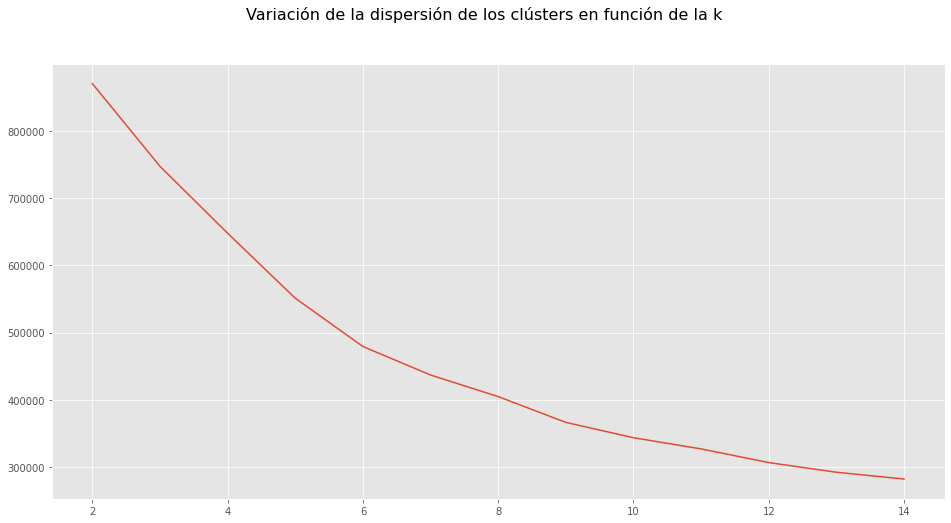

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

<a id = "segmentacion"></a>
# Segmentación de los clientes con la "k adecuada"
[Volver al índice](#table_of_contents)

Ahora que hemos determinado el número de centroides correcto podemos fittear nuestro pipeline con la ***k adecuada.***

Dado que vamos a realizar nuestra segmentación con KMeans y vamos a suministrarle las variables de nuestro interés, a veces, a KMeans se le conoce como **segmentación no supervisada pero guiada***. Guiada porque de alguna manera el data scientist le dice (lo guía) a que discrimine usando unas variables y no otras.

In [ ]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), 
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 5))
])

In [ ]:
df_final.shape

(99440, 8)

In [ ]:
pipe.fit(df_final) #fit con todos los pasos, par que los outliers no afecten a donde ponemos los centroides

Pipeline(steps=[('Imputer', KNNImputer()),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['max_pay', 'min_pay', 'mean_pay',
                                           'total_pay', 'max_seq',
                                           'time_since_last_purchase',
                                           'delivery_time', 'delay'],
                                  index=['861eff4711a542e4b93843c6dd7febb0',
                                         '290c77bc529b7ac935b93aa66c333dc3',
                                         '060e732b5b29e8181a18229c7b0b2b5e',
                                         '259dac757896d24d7702b9acbbff3f3c',
                                         '345ecd01c3...
                                         '5f102dd37243f152aec3607970aad100',
                                         '9c0096673baf55453a50073f12d1a37f',
                                         '2e6a42a9b5cbb0da62988694f18ee295',
                                        

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados. 

Esto viene muy útil porque en nuestro caso, cuando vamos a hacer el predict (asignar a cada cliente su centroide), queremos imputar los nulos, crear las variables necesarias y estandarizar (paso 1, 3 y 5 del pipe), pero **no filtrar los outliers** (todos los clientes tienen que tener un grupo). Si hacemos el predict con todo el pipeline, algunos clientes no se van a asignar a ningún grupo.

In [ ]:
# creamos un dataframe escalado con los pasos 1, 2, 3 y 5

X_processed = pipe[:3].transform(df_final)  #transform sense fer el pas dels outliers, pq també volem assignar-los a algun dels clusters trobats al fit

X_scaled = pipe["StandardScaler"].transform(X_processed) #df escalat, a partir del df net anterior, amb el que farem el predict

X_scaled.shape

(96095, 11)

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

In [ ]:
labels #el cluster de cada client

array([0, 0, 1, ..., 2, 0, 2], dtype=int32)

In [ ]:
pipe["Clustering"]

KMeans(n_clusters=5)

In [ ]:
# le asignamos el grupo 'cluster' al que pertenece cada usuario, creando la columna en el dataset
# SI LO HACEMOS AL ESCALADO (X_scaled) LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

(96095, 12)

In [ ]:
X_processed.head()

,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay,mean_fracc,max_fracc,cluster
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160.0,160.0,6.0,6.0,-5.0,-5.0,1.0,1.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163.0,163.0,3.0,3.0,-5.0,-5.0,1.0,1.0,0
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585.0,585.0,25.0,25.0,-2.0,-2.0,1.0,1.0,1
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369.0,369.0,20.0,20.0,-12.0,-12.0,1.0,1.0,2
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336.0,336.0,13.0,13.0,-8.0,-8.0,1.0,1.0,2


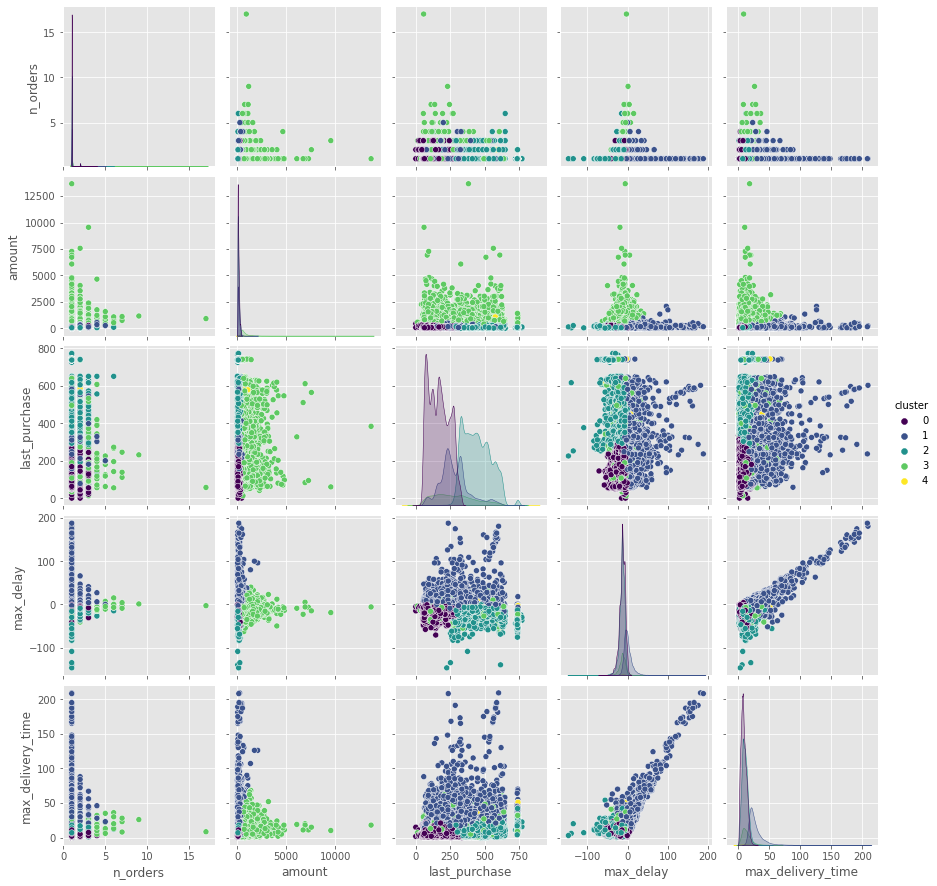

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver que tal han quedado.
selected_columns = ['n_orders', 'amount', 'last_purchase', 'max_delay', 'max_delivery_time']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster', palette = 'viridis');

<a id = "rfm"></a>
# Modelo RFM
[Volver al índice](#table_of_contents)

En esta sección vamos a ver como se puede implementar muy facilmente una segmentación basada en 3 indicadores claves de: ***recencia, frecuencia y valor monetario (RFM).***

De alguna manera, hasta ahora, hemos creado variables relacionadas con este modelo.

In [ ]:
# calculamos los indicadores de RFM
QUANTILES = 5
X_processed['recency'] = pd.qcut(X_processed['last_purchase'], q = QUANTILES, labels = range(QUANTILES))
X_processed['frequency'] = (X_processed['n_orders'] > 1).astype(int)
X_processed['monetary_value'] = pd.qcut(X_processed['amount'], q = QUANTILES, labels = range(QUANTILES))

In [ ]:
X_processed.sort_values('amount') #al ordenar-ho podem veure els valors posats a monetary_value p.e.

,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay,mean_fracc,max_fracc,cluster,recency,frequency,monetary_value
968fac81e2c44fb6c1e3ac2a45e6a102,1,0.00,0.000,44.0,44.0,3.000000,3.0,-5.200000,-5.2,1.0,1.0,0,0,0,0
4fa4365000c7090fcb8cad5713c6d3db,1,0.00,0.000,50.0,50.0,3.000000,3.0,-5.200000,-5.2,1.0,1.0,0,0,0,0
317cfc692e3f86c45c95697c61c853a6,1,9.59,9.590,52.0,52.0,3.000000,3.0,-5.000000,-5.0,2.0,2.0,0,0,0,0
bd06ce0e06ad77a7f681f1a4960a3cc6,1,10.07,10.070,398.0,398.0,4.000000,4.0,-8.000000,-8.0,1.0,1.0,2,3,0,0
b33336f46234b24a613ad9064d13106d,1,10.89,10.890,117.0,117.0,12.000000,12.0,-8.000000,-8.0,1.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc4802a71eae9be1dd28f5d788ceb526,1,6929.31,6929.310,611.0,611.0,18.000000,18.0,-6.000000,-6.0,1.0,1.0,3,4,0,4
763c8b1c9c68a0229c42c9fc6f662b93,1,7274.88,7274.880,94.0,94.0,11.000000,11.0,-7.000000,-7.0,1.0,1.0,3,0,0,4
da122df9eeddfedc1dc1f5349a1a690c,2,7571.63,3785.815,564.0,564.0,15.000000,15.0,-18.500000,-15.0,1.0,1.0,3,4,1,4
46450c74a0d8c5ca9395da1daac6c120,3,9553.02,3184.340,60.0,84.0,9.466667,10.2,-21.666667,-19.0,1.0,1.0,3,0,1,4


In [ ]:
X_processed.pivot_table(index = 'recency', values = ['last_purchase'], aggfunc = [len, np.mean]) #grups equilibrats en nombre de mostres però la mitjana varia molt

,len,mean
,last_purchase,last_purchase
recency,,
0,19324.0,94.166839
1,19299.0,185.444842
2,19043.0,270.176338
3,19300.0,366.464093
4,19129.0,524.501124


In [ ]:
X_processed.pivot_table(index = 'monetary_value', values = ['amount'], aggfunc = [len, np.mean])

,len,mean
,amount,amount
monetary_value,,
0,19221.0,39.742998
1,19219.0,70.697066
2,19222.0,108.824944
3,19214.0,165.842255
4,19219.0,447.885889


In [ ]:
X_processed.pivot_table(index = 'frequency', values = ['n_orders'], aggfunc = [len, np.mean])   #molts més del grup 0 que vol dir que han comprat 1 cop

,len,mean
,n_orders,n_orders
frequency,,
0,93098,1.000000
1,2997,2.116116


In [ ]:
rm_df = pd.crosstab(X_processed['recency'], X_processed['monetary_value'])

In [ ]:
rm_df

monetary_value,0,1,2,3,4
recency,,,,,
0,3842,3662,3883,3999,3938
1,3748,3653,3924,4061,3913
2,3951,3716,3789,3945,3642
3,3697,4147,3824,3724,3908
4,3983,4041,3802,3485,3818


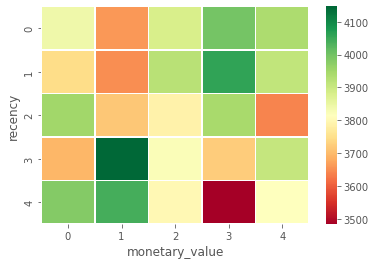

In [ ]:
sns.heatmap(rm_df, cmap = 'RdYlGn', linewidths = 0.5)

In [ ]:
X_processed[['recency', 'frequency', 'monetary_value', "n_orders"]].groupby(['recency', 'frequency', 'monetary_value']).agg('count')

n_orders
recency frequency monetary_value          
0       0         0                   3835
                  1                   3629
                  2                   3798
                  3                   3841
                  4                   3529
        1         0                      7
                  1                     33
                  2                     85
                  3                    158
                  4                    409
1       0         0                   3738
                  1                   3622
                  2                   3848
                  3                   3902
                  4                   3567
        1         0                     10
                  1                     31
                  2                     76
                  3                    159
                  4                    346
2       0         0                   3949
                  1                   3689
                  2                   3706
                  3                   3784
                  4                   3286
        1         0                      2
                  1                     27
                  2                     83
                  3                    161
                  4                    356
3       0         0                   3692
                  1                   4110
                  2                   3725
                  3                   3575
                  4                   3607
        1         0                      5
                  1                     37
                  2                     99
                  3                    149
                  4                    301
4       0         0                   3975
                  1                   4003
                  2                   3729
                  3                   3366
                  4                   3593
        1         0                      8
                  1                     38
                  2                     73
                  3                    119
                  4                    225

<a id = "ficha"></a>
# Ficha de los clientes
[Volver al índice](#table_of_contents)

El último paso, usa vez que tenemos hecha nuestra segmentación completa es crear una ***ficha resumen*** de cada grupo con las principales variables de negocio o con aquellas que no se han utilizado en la segmentación para hacer un seguimiento periódico de los grupos o para enviar como documento al resto de los departamentos de la empresa.

In [ ]:
ficha_df = pd.DataFrame()
ficha_df

""


In [ ]:
for i, col in enumerate(["amount", "n_orders", "last_purchase", "mean_delay"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
ficha_df

cluster                      0            1  ...             3            4
amount        mean  116.263184   140.552329  ...    751.885822   153.516818
              std    75.650547   100.506695  ...    545.923915   184.507081
              min     0.000000    14.860000  ...    309.160000    19.000000
              25%    57.510000    68.040000  ...    444.170000    64.952500
              50%    97.465000   115.370000  ...    593.645000   101.460000
              75%   157.720000   183.730000  ...    843.455000   161.210000
              max   460.370000  2092.860000  ...  13664.080000  1436.460000
n_orders      mean    1.020694     1.039639  ...      1.100324     1.045455
              std     0.149278     0.208380  ...      0.461809     0.226181
              min     1.000000     1.000000  ...      1.000000     1.000000
              25%     1.000000     1.000000  ...      1.000000     1.000000
              50%     1.000000     1.000000  ...      1.000000     1.000000
              75%     1.000000     1.000000  ...      1.000000     1.000000
              max     4.000000     5.000000  ...     17.000000     3.000000
last_purchase mean  167.056324   281.473989  ...    281.854222   326.018939
              std    73.796858   109.013538  ...    148.895879   160.483975
              min     0.000000    57.000000  ...     13.000000    54.000000
              25%   103.000000   215.000000  ...    161.000000   182.750000
              50%   164.000000   262.000000  ...    265.000000   321.000000
              75%   229.000000   327.000000  ...    380.000000   456.250000
              max   335.000000   743.000000  ...    743.000000   743.000000
mean_delay    mean  -13.789809     0.237781  ...    -13.620180   -12.254798
              std     7.253353    12.759824  ...      8.476121     9.580152
              min   -71.000000   -52.000000  ...    -63.000000   -54.000000
              25%   -18.000000    -7.000000  ...    -18.000000   -17.000000
              50%   -13.000000    -2.000000  ...    -13.000000   -12.000000
              75%    -9.000000     4.000000  ...     -9.000000    -8.000000
              max     7.000000   188.000000  ...     40.000000    29.000000

[28 rows x 5 columns]

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
    "Logística"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Retrasos"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Monetarios', 'Importe', 'Media'),
 ('Monetarios', 'Importe', 'Desviación'),
 ('Monetarios', 'Importe', 'Mínimo'),
 ('Monetarios', 'Importe', 'Perc. 25'),
 ('Monetarios', 'Importe', 'Perc. 50'),
 ('Monetarios', 'Importe', 'Perc. 75'),
 ('Monetarios', 'Importe', 'Máximo'),
 ('Fidelización', 'Nr. de compras', 'Media'),
 ('Fidelización', 'Nr. de compras', 'Desviación'),
 ('Fidelización', 'Nr. de compras', 'Mínimo'),
 ('Fidelización', 'Nr. de compras', 'Perc. 25'),
 ('Fidelización', 'Nr. de compras', 'Perc. 50'),
 ('Fidelización', 'Nr. de compras', 'Perc. 75'),
 ('Fidelización', 'Nr. de compras', 'Máximo'),
 ('Fidelización', 'Última compra', 'Media'),
 ('Fidelización', 'Última compra', 'Desviación'),
 ('Fidelización', 'Última compra', 'Mínimo'),
 ('Fidelización', 'Última compra', 'Perc. 25'),
 ('Fidelización', 'Última compra', 'Perc. 50'),
 ('Fidelización', 'Última compra', 'Perc. 75'),
 ('Fidelización', 'Última compra', 'Máximo'),
 ('Logística', 'Retrasos', 'Media'),
 ('Logística', 'Ret

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
index_ficha

MultiIndex([(  'Monetarios',        'Importe',      'Media'),
            (  'Monetarios',        'Importe', 'Desviación'),
            (  'Monetarios',        'Importe',     'Mínimo'),
            (  'Monetarios',        'Importe',   'Perc. 25'),
            (  'Monetarios',        'Importe',   'Perc. 50'),
            (  'Monetarios',        'Importe',   'Perc. 75'),
            (  'Monetarios',        'Importe',     'Máximo'),
            ('Fidelización', 'Nr. de compras',      'Media'),
            ('Fidelización', 'Nr. de compras', 'Desviación'),
            ('Fidelización', 'Nr. de compras',     'Mínimo'),
            ('Fidelización', 'Nr. de compras',   'Perc. 25'),
            ('Fidelización', 'Nr. de compras',   'Perc. 50'),
            ('Fidelización', 'Nr. de compras',   'Perc. 75'),
            ('Fidelización', 'Nr. de compras',     'Máximo'),
            ('Fidelización',  'Última compra',      'Media'),
            ('Fidelización',  'Última compra', 'Desviación'),
        

In [ ]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#table_of_contents)

Los algoritmos no supervisados son herramientas **muy potentes** que cualquier data scientist debe tener a mano. Saber el funcionamiento y hacer la correcta implementación de estos, puede permitir **extraer información muy valiosa y tomar mejores decisiones de negocio**. Hemos visto diferentes algoritmos y técnicas no supervisadas (***KMeans y modelo RFM***) que nos permiten crear **grupos homogéneos y accionables** de clientes y así mejorar los indicadores de la compañia.

Además de esto, hemos aprendido a utilizar los pipelines de sklearn para **automatizar al máximo el tratamiento de datos** así como implementar nuestros propios ***Transformers*** que puede ser utilizados dentro del pipeline.